In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import nbodykit.lab as nb

In [3]:
def get_pmeans(cap, iscont, method, nside):
    
    path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
    pks = glob(f'{path}spectra_{cap}_{method}_mainhighz_{nside}_v7_{iscont}_*_main.json')
    
    nmocks = len(pks)
    print(nmocks)
    
    
    pk = []

    for pki in pks:
        
        dpk = nb.ConvolvedFFTPower.load(pki) 
        
        pk.append([dpk.poles['power_0'].real-dpk.attrs['shotnoise'], 
                   dpk.poles['power_2'].real])
        
        
    pk = np.array(pk)
    print(pk.shape)
    result = np.column_stack([dpk.poles['k'], dpk.poles['modes'], 
                             np.mean(pk[:, 0, :], axis=0), 
                             np.mean(pk[:, 1, :], axis=0)])
    
    return result


def get_covmax(cap, iscont, method, nside):
    
    path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
    pks = glob(f'{path}spectra_{cap}_{method}_mainhighz_{nside}_v7_{iscont}_*_main.json')
    
    nmocks = len(pks)
    print(nmocks)
    
    
    pk = []

    for pki in pks:
        
        dpk = nb.ConvolvedFFTPower.load(pki) 
        
        pk.append([dpk.poles['power_0'].real-dpk.attrs['shotnoise'], 
                   dpk.poles['power_2'].real])
        
        
    pk = np.array(pk)
    nmocks = pk.shape[0]
    nbins = pk.shape[-1]
    hartlapf = (nmocks - 1.) / (nmocks - nbins - 2.)
    
    #print(pk.shape)
    
    result = {'k':dpk.poles['k'], 
              'nmodes':dpk.poles['modes'], 
              'covp0':np.cov(pk[:, 0, :], rowvar=False)*hartlapf,
              'covp2':np.cov(pk[:, 1, :], rowvar=False)*hartlapf}
    
    return result

def get_p0cov(cap):
    
    path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
    pks = glob(f'{path}spectra_{cap}_knownsystot_mainhighz_512_v7_0_*_main.json')
    
    nmocks = len(pks)
    print(nmocks)
    
    
    pk = []

    for pki in pks:
        
        dpk = nb.ConvolvedFFTPower.load(pki)   
        pk.append(dpk.poles['power_0'].real-dpk.attrs['shotnoise'])

    pk = np.array(pk)    
    
    return np.cov(pk, rowvar=False)    

In [ ]:
# measure mean spectra of the mocks
pks = {}

methods = {'nnall':'all',
           'nnknown':'known',
           'standard':'knownsystot'}
isconts = {'null':'0',
          'cont':'1'}
caps = ['NGC'] #, 'SGC']

for cap in caps:
    for iscont in ['null', 'cont']:
        for method in ['nnall', 'nnknown', 'standard']:
            
            nsides = ['512', '256'] if method!='standard' else ['512']
            
            for nside in nsides:
                
                name = '_'.join([cap, iscont, method, nside])                
                print(name)                
                
                pk_ = get_pmeans(cap, isconts[iscont], methods[method], nside)                
                pks[name] = pk_
                
np.savez('./pk_mocks_ngc_v1.0', **pks)                

In [4]:
# measure cov. matrix spectra of the mocks
covpks = {}

methods = {'nnall':'all',
           'nnknown':'known',
           'standard':'knownsystot'}
isconts = {'null':'0',
          'cont':'1'}
caps = ['NGC'] #, 'SGC']

for cap in caps:
    for iscont in ['null', 'cont']:
        for method in ['nnall', 'nnknown', 'standard']:
            
            nsides = ['512', '256'] if method!='standard' else ['512']
            
            for nside in nsides:
                
                name = '_'.join([cap, iscont, method, nside])                
                #print(name)                
                
                pk_ = get_covmax(cap, isconts[iscont], methods[method], nside)                
                covpks[name] = pk_
                
np.savez('./covpk_mocks_ngc_v1.0', **covpks)

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [2]:
covpks = np.load('./covpk_mocks_ngc_v1.0.npz', allow_pickle=True)
covpks.files

['NGC_null_nnall_512',
 'NGC_null_nnall_256',
 'NGC_null_nnknown_512',
 'NGC_null_nnknown_256',
 'NGC_null_standard_512',
 'NGC_cont_nnall_512',
 'NGC_cont_nnall_256',
 'NGC_cont_nnknown_512',
 'NGC_cont_nnknown_256',
 'NGC_cont_standard_512']

In [7]:
covpks['NGC_cont_nnknown_512'].item()['k'].size

128

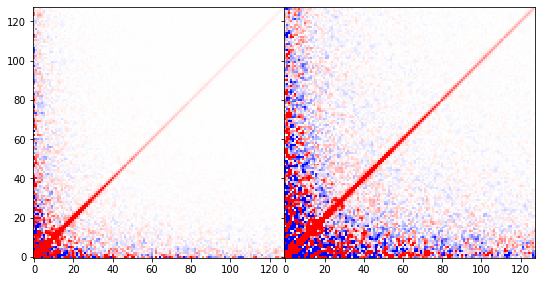

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 5), sharey=True)
fig.subplots_adjust(wspace=0.0)
kw = dict(origin='lower', vmin=-1.0, vmax=1.0, cmap=plt.cm.bwr)
ax[0].imshow(covpks['NGC_cont_nnknown_512'].item()['covp0']*1.0e-6,**kw) 
ax[1].imshow(covpks['NGC_cont_nnknown_512'].item()['covp2']*1.0e-6,**kw) 

In [3]:
p0ngc = get_p0cov('NGC')

1000


In [4]:
p0sgc = get_p0cov('SGC')

200


In [5]:
path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
np.savetxt(f'{path}spectra_NGC_knownsystot_mainhighz_512_v7_0_1to1000_6600_512_main.dat', p0ngc)
np.savetxt(f'{path}spectra_SGC_knownsystot_mainhighz_512_v7_0_1to1000_6600_512_main.dat', p0sgc)

In [6]:
np.percentile(p0ngc, [0, 100])

array([-5.60135901e+06,  1.27307186e+09])

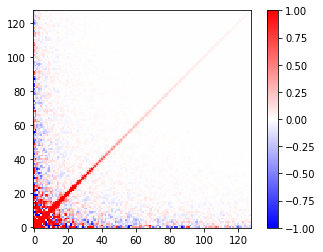

In [7]:
plt.imshow(p0ngc/1.0e6,  origin='lower', vmin=-1.0, vmax=1.0, cmap=plt.cm.bwr)
plt.colorbar()

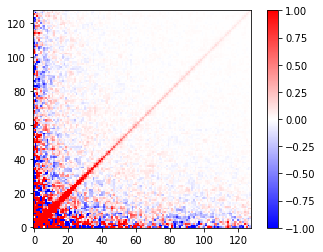

In [8]:
plt.imshow(p0sgc/1.0e6,  origin='lower', vmin=-1.0, vmax=1.0, cmap=plt.cm.bwr)
plt.colorbar()

In [2]:
pks = np.load('./pk_mocks_ngc_v1.0.npz', allow_pickle=True)
pks.files

['NGC_null_nnall_512',
 'NGC_null_nnall_256',
 'NGC_null_nnknown_512',
 'NGC_null_nnknown_256',
 'NGC_null_standard_512',
 'NGC_cont_nnall_512',
 'NGC_cont_nnall_256',
 'NGC_cont_nnknown_512',
 'NGC_cont_nnknown_256',
 'NGC_cont_standard_512']

Text(0, 0.5, 'kP$_\\ell$ [Mpc/h]$^{2}$')

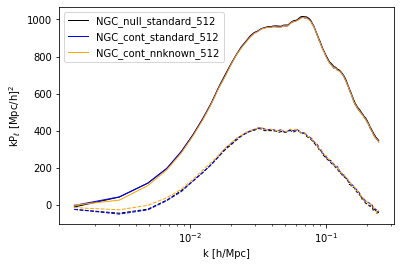

In [3]:
c  = ['k', 'b', 'orange']
for i, method in enumerate(['NGC_null_standard_512', 
                            'NGC_cont_standard_512',
                            'NGC_cont_nnknown_512']):
    
    # axis=1 index 0:k, 1:nmodes, 2:p0, 3:p2    
    k_ = pks[method][:, 0]
    p0 = pks[method][:, 2]
    p2 = pks[method][:, 3]
    
    plt.plot(k_, k_*p0, color=c[i], lw=1, label=method)
    plt.plot(k_, k_*p2, color=c[i], lw=1, ls='--')
    
plt.xscale('log');plt.legend()
plt.xlabel('k [h/Mpc]');plt.ylabel(r'kP$_\ell$ [Mpc/h]$^{2}$')

In [24]:
pks['NGC_KNOWN_512_NULL'].shape

(128, 4)

Text(0, 0.5, 'P$_{\\ell}$')

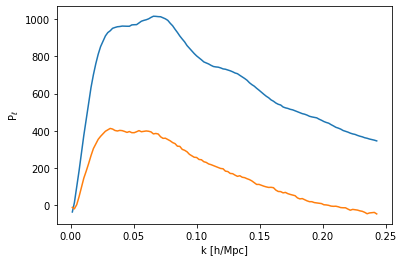

In [25]:
k_ = pks['NGC_KNOWN_512_NULL'][:, 0]

for i in [2, 3]:
    pi_ = pks['NGC_KNOWN_512_NULL'][:, i]
    
    plt.plot(k_, k_*pi_)
    
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P$_{\ell}$')

In [27]:
np.savetxt('./test_mock_pk_known_512_null.txt', pks['NGC_KNOWN_512_NULL'], 
           header='k - nmodes - p0 - p2')

In [28]:
!head ./test_mock_pk_known_512_null.txt

# k - nmodes - p0 - p2
1.408580787549475709e-03 3.300000000000000000e+01 -2.583418164062500000e+04 -8.261441406250000000e+03
3.016361459133039703e-03 2.240000000000000000e+02 4.338680175781250000e+03 -6.507510742187500000e+03
4.894268791212779551e-03 6.680000000000000000e+02 2.063658593750000000e+04 6.197957763671875000e+02
6.745221186903896035e-03 1.184000000000000000e+03 2.745113281250000000e+04 6.811818359375000000e+03
8.613807931576003205e-03 2.060000000000000000e+03 3.252899023437500000e+04 1.114280175781250000e+04
1.049533751540886010e-02 2.984000000000000000e+03 3.572552734375000000e+04 1.383878027343750000e+04
1.240987769249200616e-02 4.360000000000000000e+03 3.724769140625000000e+04 1.477654589843750000e+04
1.431138339830747078e-02 5.564000000000000000e+03 3.825435546875000000e+04 1.562868359375000000e+04
1.620876991383812804e-02 7.328000000000000000e+03 3.903132031250000000e+04 1.643931054687500000e+04


In [9]:
ind = np.random.choice(np.arange(100), size=20, replace=False)
ind

array([97, 44,  0, 10, 88, 86, 37, 26,  4, 91,  3, 58, 75, 66, 36, 25, 92,
       67,  1, 50])

In [10]:
pk_m = np.mean(pk, axis=0)

c = ['b', 'orange', 'g']
ell = [0, 2]

for j in range(pk_m.shape[0]):
    plt.plot(k, k*pk_m[j, :], marker='.', color=c[j], lw=2, label=r'$\ell$=%d'%ell[j])
        
    for ix in range(100):
        plt.plot(k, k*pk[ix, j, :], lw=0.5, color=c[j], alpha=0.1)

plt.ylim(-300, 1200.)
plt.xlim(xmax=0.3)
plt.legend()
plt.ylabel('kP$_{\ell}$ [Mpc/h]$^{3}$')
plt.xlabel('k [h/Mpc]')

NameError: name 'pk' is not defined

In [11]:
pk.shape

(100, 2, 128)

In [15]:
p0cov = np.cov(pk[:, 0, :], rowvar=False)

In [16]:
np.savetxt('/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/spectra_NGC_knownsystot_mainhighz_512_v7_0_1to100_6600_512_main.dat',
          p0cov)

In [6]:
pk.shape

(100, 3, 39)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')


from lssutils.lab import run_ConvolvedFFTPower
from lssutils import setup_logging
import nbodykit.cosmology as cosmo

In [2]:
setup_logging('info')

In [3]:
_h = 0.6777
_Ob0 = 0.048206
_Ocdm0 = 0.307115 - _Ob0
ezcosmo = cosmo.Cosmology(h=_h, Omega_b=_Ob0, Omega_cdm=_Ocdm0,
                               m_ncdm=None, n_s=0.9611, T_cmb=2.7255).match(sigma8=0.8225)

In [4]:
# path to the catalogs and output pk
inpath = '/home/mehdi/data/eboss/mocks/1.0/catalogs_raw/null/' 
outpath = '/home/mehdi/data/eboss/mocks/test/pk_null/'

mockid = 1                         # this will be the input
mockid = f'{mockid:04d}'           # 1 to 0001

# inputs and output names
output_fn = os.path.join(outpath, f'pk_null_mock_{mockid}_test_512.json')
dat_fn = f'{inpath}EZmock_eBOSS_QSO_NGC_v7_noweight_{mockid}.dat.fits'
ran_fn = dat_fn.replace('.dat.', '.ran.')

print(f'data: {dat_fn}')
print(f'ran: {ran_fn}')
print(f'output: {output_fn}')

data: /home/mehdi/data/eboss/mocks/1.0/catalogs_raw/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0001.dat.fits
ran: /home/mehdi/data/eboss/mocks/1.0/catalogs_raw/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0001.ran.fits
output: /home/mehdi/data/eboss/mocks/test/pk_null/pk_null_mock_0001_test_512.json


In [5]:
pk = run_ConvolvedFFTPower(dat_fn, ran_fn, output_fn, zmin=0.8, zmax=2.2, 
                           cosmology='ezmock', boxsize=5000., nmesh=512,
                           dk=0.01, kmax=0.4, return_pk=True)

[ 000012.98 ]   0: 09-30 11:35  CatalogSource   INFO     Extra arguments to FileType: ('/home/mehdi/data/eboss/mocks/1.0/catalogs_raw/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0001.dat.fits',) {}
[ 000012.99 ]   0: 09-30 11:35  CatalogSource   INFO     Extra arguments to FileType: ('/home/mehdi/data/eboss/mocks/1.0/catalogs_raw/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0001.ran.fits',) {}
[ 000028.72 ]   0: 09-30 11:35  FKPCatalog      INFO     cartesian coordinate range: [-3304.45634877 -3228.85327133   540.55382461] : [-190.25777525 3305.01599137 3285.08130468]
[ 000028.72 ]   0: 09-30 11:35  FKPCatalog      INFO     BoxSize = [5000. 5000. 5000.]
[ 000028.72 ]   0: 09-30 11:35  FKPCatalog      INFO     BoxCenter = [-1747.35706201    38.08136002  1912.81756464]
[ 000028.74 ]   0: 09-30 11:35  ConvolvedFFTPower INFO     using compensation function CompensateTSC for source 'first'
[ 000028.74 ]   0: 09-30 11:35  ConvolvedFFTPower INFO     using compensation function CompensateTSC for source 'se

In [6]:
Plin = cosmo.LinearPower(ezcosmo, redshift=1.5, transfer='CLASS')

In [7]:
import nbodykit.lab as nb

In [9]:
pk = nb.ConvolvedFFTPower.load('/home/mehdi/data/eboss/mocks/test/pk_null/pk_null_mock_0001_test.json')
pk_ = nb.ConvolvedFFTPower.load('/home/mehdi/data/eboss/mocks/test/pk_null/pk_null_mock_0001_test_512.json')

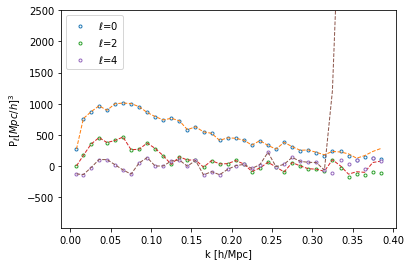

In [15]:
for i in [0, 2, 4]:
    
    a = 1.0 if i==0 else 0.0
    
    plt.plot(pk.poles['k'], pk.poles['k']*(pk.poles['power_%d'%i].real-a*pk.attrs['shotnoise']),
            marker='.', mfc='w', ls='None', lw=1, label=r'$\ell$=%d'%i)
    plt.plot(pk_.poles['k'], pk_.poles['k']*(pk_.poles['power_%d'%i].real-a*pk_.attrs['shotnoise']),
             ls='--', lw=1)
    
    #plt.plot(pk2.poles['k'], pk2.poles['k']*(pk2.poles['power_%d'%i].real-a*pk2.attrs['shotnoise']))
    
# k = np.linspace(0, 0.4, 100)
# plt.plot(k, 8*k*Plin(k)-300., c='b', zorder=-1, alpha=0.2)

plt.ylim(ymax=2500)
plt.xlabel(r'k [h/Mpc]')
plt.ylabel(r'P$_{\ell} [Mpc/h]^{3}$')
plt.legend()

In [19]:
is_good = abs(pk_.poles['k']-pk.poles['k']) < 1.0e-8

[0.99940473 1.00000739]
[-0.58587134  1.05415642]
[-8.47871494  2.55706954]


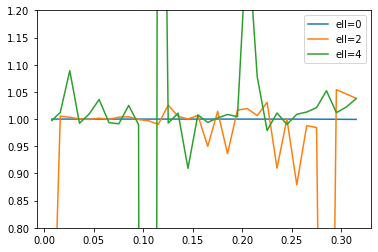

In [22]:
for i in [0, 2, 4]:
    y_r = pk.poles['power_%d'%i].real[is_good]/pk_.poles['power_%d'%i].real[is_good]
    plt.plot(pk.poles['k'][is_good], y_r, label='ell=%d'%i)
    print(np.percentile(y_r, [0, 100]))
    
plt.ylim(0.8, 1.2)
plt.legend()

In [35]:
pk.poles.coords

{'k': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
        0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
        0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
        0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355,
        0.365, 0.375, 0.385])}